In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Stap 1: Data inladen
Diefstal = pd.read_csv('Diefstal.csv', delimiter=';')
inkomen = pd.read_csv('inkomen.csv', delimiter=';', low_memory=False)
gdf_provincie = gpd.read_file('Provincie.json')
gdf_nederland = gpd.read_file('Nederland.json')
gdf = gpd.read_file('Landsdelen.geojson')


# Stap 2: Gegevens bewerken
# Voor de 'Diefstal' dataset
Diefstal['Perioden'] = Diefstal['Perioden'].str[:-4]
mapping = {
    'T001540': 'diefstallen totaal',
    'A048105': 'diefstallen geweld',
    'A048106': 'diefstallen geen geweld'
}
Diefstal['SoortDiefstal'] = Diefstal['SoortDiefstal'].replace('CRI1121', 'alle diefstallen')
Diefstal['GebruikVanGeweld'] = Diefstal['GebruikVanGeweld'].replace(mapping)

# Voor de 'inkomen' dataset
inkomen['Perioden'] = inkomen['Perioden'].str[:-4]
inkomen['KenmerkenVanHuishoudens'] = inkomen['KenmerkenVanHuishoudens'].replace('1050010', 'inclusief studenten')

# Stap 3: Verwijder dubbele rijen
Diefstal.drop_duplicates(subset=['Perioden', 'RegioS', 'GebruikVanGeweld'], inplace=True)
inkomen.drop_duplicates(subset=['Perioden', 'RegioS'], inplace=True)

# Stap 4: Dataframes samenvoegen
df = pd.merge(inkomen, Diefstal, on=['RegioS', 'Perioden'], how='left')
# Replace missing values with 0 in the 'GeregistreerdeDiefstallenPer1000Inw_3' column of the original DataFrame
df['GeregistreerdeDiefstallenPer1000Inw_3'] = pd.to_numeric(df['GeregistreerdeDiefstallenPer1000Inw_3'], errors='coerce')
df['GeregistreerdeDiefstallenPer1000Inw_3'].fillna(0, inplace=True)
df['Perioden'] = df['Perioden'].astype(int)

# Stap 5: Mapping toevoegen
landsdeel_mapping = {'LD01  ': 'Noord-Nederland',
                 'LD02  ': 'Oost-Nederland',
                 'LD03  ': 'Zuid-Nederland',
                 'LD04  ': 'West-Nederland'}

provincie_mapping = {
    'PV20  ': 'Groningen',
    'PV21  ': 'Friesland',
    'PV22  ': 'Drenthe',
    'PV23  ': 'Overijssel',
    'PV24  ': 'Flevoland',
    'PV25  ': 'Gelderland',
    'PV26  ': 'Utrecht',
    'PV27  ': 'Noord-Holland',
    'PV28  ': 'Zuid-Holland',
    'PV29  ': 'Zeeland',
    'PV30  ': 'Noord-Brabant',
    'PV31  ': 'Limburg'
}

df['Nederland'] = df['RegioS'].map({'NL01  ': 'Nederland'}).fillna('')
df['Landsdeel'] = df['RegioS'].map(landsdeel_mapping).fillna('')
df['Provincie'] = df['RegioS'].map(provincie_mapping).fillna('')

sub_df_nederland = df[df['Nederland'] != '']
sub_df_landsdeel = df[df['Landsdeel'] != '']
sub_df_provincie = df[df['Provincie'] != '']

# Filter de GeoDataFrame om alleen rijen te behouden waarin "NAME_LATN" gelijk is aan "Netherlands" en "LEVL_CODE" gelijk is aan 1
gdf_landsdelen = gdf[(gdf['CNTR_CODE'] == 'NL') & (gdf['LEVL_CODE'] == 1)]

merged_Provinciedf = sub_df_provincie.merge(gdf_provincie[['name_1', 'geometry']], left_on='Provincie', right_on='name_1', how='left')
merged_Nederlandsedf = sub_df_nederland.merge(gdf_nederland[['name_local', 'geometry']], left_on='Nederland', right_on='name_local', how='left')
merged_Landsdeeldf = sub_df_landsdeel.merge(gdf_landsdelen[['NUTS_NAME', 'geometry']], left_on='Landsdeel', right_on='NUTS_NAME', how='left')

gdf_provincie = gpd.GeoDataFrame(merged_Provinciedf, geometry='geometry')
gdf_nederland = gpd.GeoDataFrame(merged_Nederlandsedf, geometry='geometry')
gdf_landsdeel = gpd.GeoDataFrame(merged_Landsdeeldf, geometry='geometry')

gdf_provincie['DI-Index'] = (gdf_provincie['GeregistreerdeDiefstallenPer1000Inw_3'] / gdf_provincie['GemiddeldGestandaardiseerdInkomen_3']) * 100
gdf_landsdeel['DI-Index'] = (gdf_landsdeel['GeregistreerdeDiefstallenPer1000Inw_3'] / gdf_landsdeel['GemiddeldGestandaardiseerdInkomen_3']) * 100
gdf_nederland['DI-Index'] = (gdf_nederland['GeregistreerdeDiefstallenPer1000Inw_3'] / gdf_nederland['GemiddeldGestandaardiseerdInkomen_3']) * 100



C:\Users\elayz\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
2023-09-27 21:19:00.875 
  command:

    streamlit run C:\Users\elayz\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


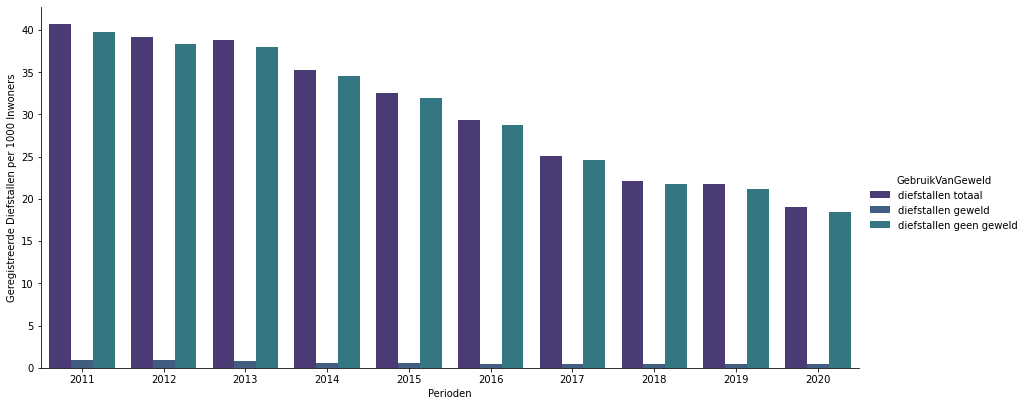

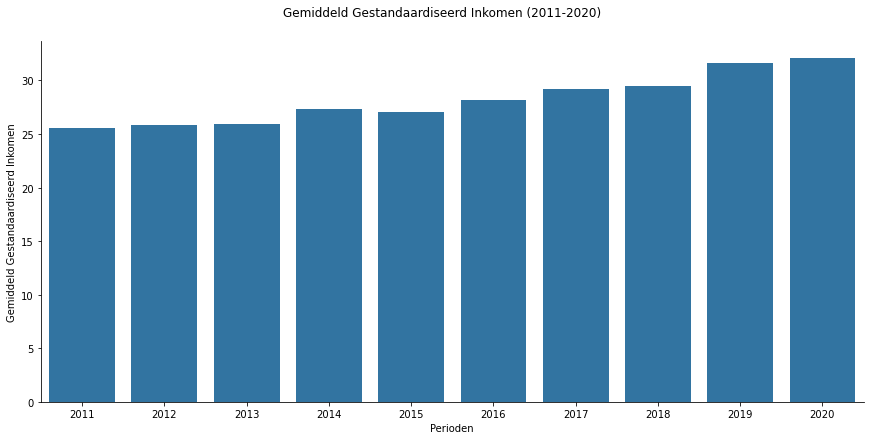

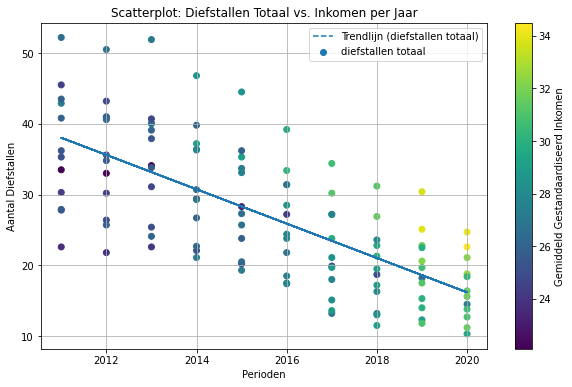

In [2]:
import streamlit as st
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress  

# Inhoudsopgave
st.sidebar.title('Inhoudsopgave')
option = st.sidebar.radio('Selecteer een optie', ['Alle jaartallen', 'Bepaald jaar'])
custom_palette = sns.color_palette('viridis')  # Pas dit aan aan het gewenste kleurenschema

if option == 'Alle jaartallen':
    st.write("Algemene gegevens.")
    tabs = st.tabs(["Diefstal Overzicht", "Inkomen Overzicht", "Scatterplot"])

    # Tab voor 'Diefstal Overzicht'
    with tabs[0]:
        st.write("Je hebt 'Diefstal Overzicht' geselecteerd.")

        gdf_nederland['Perioden'] = gdf_nederland['Perioden'].astype(int)
        
        # Streamlit-app voor gdf_nederland
        st.title('Diefstal in Nederland')
        st.write('Ontdek de gegevens over diefstallen per 1000 inwoners in Nederland door de jaren heen.')

        # Voeg een slider toe om het jaartal te selecteren
        selected_year = st.slider('Selecteer een jaar', min_value=2011, max_value=2020, value=(2011, 2020))

        
        # Voeg checkboxes toe om de waarden in de "GebruikVanGeweld" kolom te selecteren
        geweld_soorten = st.checkbox('Totaal aantal diefstallen', value=True)
        geweld_geweld = st.checkbox('Diefstallen met geweld', value=True)
        geweld_geen_geweld = st.checkbox('Diefstallen zonder geweld', value=True)

        # Filter de dataset op basis van de geselecteerde jaartallen en geweldsoorten
        selected_gebruik_geweld = []
        if geweld_soorten:
            selected_gebruik_geweld.append('diefstallen totaal')
        if geweld_geweld:
            selected_gebruik_geweld.append('diefstallen geweld')
        if geweld_geen_geweld:
            selected_gebruik_geweld.append('diefstallen geen geweld')

        filtered_df = gdf_nederland[
            (gdf_nederland['Perioden'] >= selected_year[0]) &
            (gdf_nederland['Perioden'] <= selected_year[1]) &
            (gdf_nederland['GebruikVanGeweld'].isin(selected_gebruik_geweld))
        ]

        # Maak een facetgrid voor de barplots per jaar met het aangepaste kleurenschema
        g = sns.catplot(x='Perioden', y='GeregistreerdeDiefstallenPer1000Inw_3', hue='GebruikVanGeweld',
                        data=filtered_df, kind='bar', height=6, aspect=2, palette=custom_palette)

        # Stel de titel in
        plt.subplots_adjust(top=0.9)
        
        g.set(xlabel='Perioden', ylabel='Geregistreerde Diefstallen per 1000 Inwoners')

        # Toon de plot
        st.pyplot(g)
    with tabs[1]:
        st.write('Je hebt "Inkomen Overzicht" geselecteerd.')


        # Streamlit-app voor gdf_nederland
        st.title('Inkomen')
        st.write('Ontdek de gegevens over gemiddeld gestandaardiseerd inkomen in Nederland door de jaren heen.')
        
        # Filter de dataset op basis van de geselecteerde jaartallen voor de tweede plot
        filtered_df2 = gdf_nederland[
            (gdf_nederland['Perioden'] >= selected_year[0]) &
            (gdf_nederland['Perioden'] <= selected_year[1])
        ]

        # Maak een facetgrid voor de barplots per jaar voor de tweede plot met het aangepaste kleurenschema
        g2 = sns.catplot(x='Perioden', y='GemiddeldGestandaardiseerdInkomen_3',
                        data=filtered_df2, kind='bar', height=6, aspect=2, color='#1f77b4')
    
        # Stel de titel in voor de tweede plot
        plt.subplots_adjust(top=0.9)
        g2.fig.suptitle(f'Gemiddeld Gestandaardiseerd Inkomen ({selected_year[0]}-{selected_year[1]})')
    
        g2.set(xlabel='Perioden', ylabel='Gemiddeld Gestandaardiseerd Inkomen')
    
        # Toon de tweede plot
        st.pyplot(g2)
    
    with tabs[2]:
        st.write('Je hebt "Scatterplot" geselecteerd.')
        # Streamlit-applicatie
        st.title('Scatterplot met Trendlijn: Diefstallen vs. Inkomen per Jaar')

        # Radio-buttons voor het selecteren van het type diefstal
        selected_theft_type = st.radio("Selecteer het type diefstal", ["Diefstallen Totaal", "Diefstallen Geweld", "Diefstallen Geen Geweld"])

        # Maak een scatterplot met Matplotlib
        fig, ax = plt.subplots(figsize=(10, 6))

        # Filter de gegevens op basis van het geselecteerde type diefstal
        filtered_data = merged_Provinciedf[merged_Provinciedf['GebruikVanGeweld'] == selected_theft_type.lower()]

        scatter_plot = ax.scatter(filtered_data['Perioden'], filtered_data['GeregistreerdeDiefstallenPer1000Inw_3'], c=filtered_data['GemiddeldGestandaardiseerdInkomen_3'], label=selected_theft_type.lower())

        ax.set_xlabel('Perioden')
        ax.set_ylabel('Aantal Diefstallen')
        ax.set_title(f'Scatterplot: {selected_theft_type} vs. Inkomen per Jaar')
        fig.colorbar(scatter_plot, label='Gemiddeld Gestandaardiseerd Inkomen')
        ax.grid(True)

        # Bereken en toon de trendlijn voor het geselecteerde type diefstal
        x = filtered_data['Perioden'].to_numpy()
        y = filtered_data['GeregistreerdeDiefstallenPer1000Inw_3'].to_numpy()

        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        trendline = intercept + slope * x

        # Plot de trendlijn
        ax.plot(x, trendline, linestyle='--', label=f'Trendlijn ({selected_theft_type.lower()})')

        # Toon de legenda
        ax.legend()

        # Toon de scatterplot met trendlijnen in Streamlit
        st.pyplot(fig)


else:
    st.title('DI-Index in Nederland op verschillende schalen door de jaren heen')
    # Code voor bepaald jaar
    st.write("Je hebt 'Bepaald jaar' geselecteerd.")
    # Maak een dropdown-menu voor het selecteren van een enkele geweldsoort voor gdf_nederland
    selected_geweld_soort = st.selectbox('Selecteer Geweldsoort (gdf_nederland)', 
                                                    ['diefstallen totaal', 'diefstallen geweld', 'diefstallen geen geweld'], 
                                                    index=0)  # Standaard geselecteerde waarde is 'diefstallen totaal'

    # Voeg een enkelvoudige slider toe om het jaar te selecteren voor gdf_nederland
    selected_year_1 = st.selectbox('Selecteer een jaar (gdf_provincie)', 
                                               list(range(2011, 2021)), 
                                               index=0, key='year_nederland')
    col1, col2, col3 = st.columns(3)
    with col1:

        # Voeg hier de code in voor de andere drie plaatjes
    
        # Zet de 'Perioden' kolom om naar een numeriek datatype (int)
        gdf_nederland['Perioden'] = gdf_nederland['Perioden'].astype(int)

        # Streamlit-app voor gdf_nederland


        # Filter de dataset op basis van het geselecteerde jaar en geweldsoort voor gdf_nederland
        gdf_selected_year_diefstal_nederland = gdf_nederland[(gdf_nederland['Perioden'] == selected_year_1) & (gdf_nederland['GebruikVanGeweld'] == selected_geweld_soort)]

        # Bereken de vmin en vmax waarden op basis van alle jaren voor de geselecteerde geweldsoort in gdf_nederland
        vmin_nederland = gdf_nederland[gdf_nederland['GebruikVanGeweld'] == selected_geweld_soort]['DI-Index'].min()
        vmax_nederland = gdf_nederland[gdf_nederland['GebruikVanGeweld'] == selected_geweld_soort]['DI-Index'].max()

        # Plot de provincies op basis van de DI-Index met een aangepaste range
        fig_nederland, ax_nederland = plt.subplots(1, 1, figsize=(15, 12))
        gdf_selected_year_diefstal_nederland.plot(column='DI-Index', linewidth=0.8, ax=ax_nederland, edgecolor='0.8', legend=True, vmin=vmin_nederland, vmax=vmax_nederland)
        ax_nederland.axis('off')  # Optioneel: uitschakelen van de assen

        # Toon de plot in Streamlit voor gdf_nederland
        st.pyplot(fig_nederland)
    
    with col2:
        # Streamlit-app voor gdf_landsdeel
        #st.title('DI-Index per Landsdeel in Nederland')

        # Filter de dataset op basis van het geselecteerde jaar en geweldsoort voor gdf_landsdeel
        gdf_selected_year_diefstal_landsdeel = gdf_landsdeel[(gdf_landsdeel['Perioden'] == selected_year_1) & (gdf_landsdeel['GebruikVanGeweld'] == selected_geweld_soort)]

        # Bereken de vmin en vmax waarden op basis van alle jaren voor de geselecteerde geweldsoort in gdf_landsdeel
        vmin_landsdeel = gdf_landsdeel[gdf_landsdeel['GebruikVanGeweld'] == selected_geweld_soort]['DI-Index'].min()
        vmax_landsdeel = gdf_landsdeel[gdf_landsdeel['GebruikVanGeweld'] == selected_geweld_soort]['DI-Index'].max()

        # Plot de landsdelen op basis van de DI-Index met een aangepaste range
        fig_landsdeel, ax_landsdeel = plt.subplots(1, 1, figsize=(15, 12))
        gdf_selected_year_diefstal_landsdeel.plot(column='DI-Index', linewidth=0.8, ax=ax_landsdeel, edgecolor='0.8', legend=True, vmin=vmin_landsdeel, vmax=vmax_landsdeel)
        ax_landsdeel.axis('off')  # Optioneel: uitschakelen van de assen

        # Toon de plot in Streamlit voor gdf_landsdeel
        st.pyplot(fig_landsdeel)
        
    with col3:
        # Streamlit-app voor gdf_provincie
        #st.title('DI-Index per Provincie in Nederland')

        # Filter de dataset op basis van de geselecteerde geweldsoort voor gdf_provincie
        gdf_selected_year_diefstal_provincie = gdf_provincie[(gdf_provincie['Perioden'] == selected_year_1) & (gdf_provincie['GebruikVanGeweld'] == selected_geweld_soort)]

        # Bereken de vmin en vmax waarden op basis van alle jaren voor de geselecteerde geweldsoort
        vmin_provincie = gdf_provincie[gdf_provincie['GebruikVanGeweld'] == selected_geweld_soort]['DI-Index'].min()
        vmax_provincie = gdf_provincie[gdf_provincie['GebruikVanGeweld'] == selected_geweld_soort]['DI-Index'].max()

        # Plot de provincies op basis van de DI-Index met een aangepaste range
        fig_provincie, ax_provincie = plt.subplots(1, 1, figsize=(15, 12))
        gdf_selected_year_diefstal_provincie.plot(column='DI-Index', linewidth=0.8, ax=ax_provincie, edgecolor='0.8', legend=True, vmin=vmin_provincie, vmax=vmax_provincie)
        ax_provincie.axis('off')  # Optioneel: uitschakelen van de assen

        # Toon de plot in Streamlit voor gdf_provincie
        st.pyplot(fig_provincie)
